# Summary
- Analysis of fine-tuned models

In [42]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [2]:
# loading in them all made my machine run out of memory
method_l = [
     "maxcorr", 
     "mincorr", 
     "maxlinreg", 
     "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [3]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/repr_fine_results3_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]
network_l = sorted(network_l, key=network_sort_key)

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["cca"]["corrs"][network].values()))) # god this is a hack

In [4]:
network_l

['xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_1',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_2',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_3',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_4',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_5',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_6',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_7',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_8',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_9',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10',
 'xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_0',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_1',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_2',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_3',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_4',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_5',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_6',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_7',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_8',
 'xlnet_base_cased-ptb_pos_dev_qnli.hdf5_9',
 'xlnet_

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [5]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [6]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [7]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [8]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0
           minlinreg   mincorr  maxlinreg   maxcorr
minlinreg   1.000000  0.408350   0.285199  0.118424
mincorr     0.408350  1.000000   0.138704  0.046492
maxlinreg   0.285199  0.138704   1.000000 -0.039367
maxcorr     0.118424  0.046492  -0.039367  1.000000
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_1
           minlinreg   mincorr  maxlinreg   maxcorr
minlinreg   1.000000  0.365161  -0.182078 -0.021110
mincorr     0.365161  1.000000  -0.164137 -0.030335
maxlinreg  -0.182078 -0.164137   1.000000  0.432210
maxcorr    -0.021110 -0.030335   0.432210  1.000000
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_2
           minlinreg   mincorr  maxlinreg   maxcorr
minlinreg   1.000000  0.426844  -0.190556  0.067500
mincorr     0.426844  1.000000  -0.291275  0.113796
maxlinreg  -0.190556 -0.291275   1.000000 -0.046279
maxcorr     0.067500  0.113796  -0.046279  1.000000
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_3
           minlinreg   mincorr  maxlinreg   maxcorr
minl

### Distributions

In [9]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0:

minlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0    768
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    763
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       4
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.284938  0.566832
min  0.284938  1.000000  0.400206
med  0.566832  0.400206  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     619
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0    149
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      304
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      217
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       215
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        28
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11       2
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11      1
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7         1
dtype: int64

corr_df_pctl
          max       min       me


maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11    760
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10      8
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_3       409
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7       188
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_11      35
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11     23
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        19
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_9       18
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_3      17
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_6        15
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_0       7
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0        6
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_0        5
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9         4
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0      4
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_10      4
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10        4
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_9       3
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_2        3
xlnet_base_cased-

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8      425
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_0      286
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       25
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_0      23
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_0      9
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.049253  0.146509
min  0.049253  1.000000  0.825563
med  0.146509  0.825563  1.000000

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11    764
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10      4
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_3        742
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_9         6
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0       4
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_10      3
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_0        2
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7          2
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_3        1
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_7       1
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_5  

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11     310
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9      214
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     213
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       28
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7        2
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.060808  0.030550
min  0.060808  1.000000 -0.102689
med  0.030550 -0.102689  1.000000


xlnet_base_cased-ptb_pos_dev_qnli.hdf5_1:

minlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_1    730
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_1      38
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    713
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9      38
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     13
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.243488  0.840258
min -0.243488  1.000000  0.020315
med  0.840258  0.020315  1.00000

          max       min       med
max  1.000000 -0.093739  0.981213
min -0.093739  1.000000 -0.039707
med  0.981213 -0.039707  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     243
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_4    232
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_3      227
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_5       58
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10       6
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_4       2
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       264
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      206
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      163
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        77
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      26
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11     16
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7         9
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10       5
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_9        1
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_10      1
dtype: int64

corr_d


maxcounts
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_8    768
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9     409
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8     246
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    109
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.246343  0.923744
min  0.246343  1.000000  0.322622
med  0.923744  0.322622  1.000000

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11    361
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_8     283
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_6     119
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10      5
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       282
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      147
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      146
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       103
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11     44
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      27
xlnet_base_cased-ptb_p

          max       min       med
max  1.000000  0.100803  0.180847
min  0.100803  1.000000  0.648243
med  0.180847  0.648243  1.000000

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11    523
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_9     113
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_11    108
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10     23
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_9       1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11    222
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       110
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11       68
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        59
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_0        54
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10       51
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_1        27
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_0       24
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_0      24
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0       16
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      16
xlnet_base_cased-ptb_pos_

          max       min       med
max  1.000000 -0.041509  0.630116
min -0.041509  1.000000 -0.119388
med  0.630116 -0.119388  1.000000


xlnet_base_cased-ptb_pos_dev_qqp.hdf5_2:

minlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_2    758
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_3         9
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_2        1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    671
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9      67
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     15
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8      15
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.116698  0.964241
min -0.116698  1.000000 -0.004971
med  0.964241 -0.004971  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_2    385
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     221
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_2      74
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_2       71
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10       5


          max       min       med
max  1.000000  0.217404  0.047760
min  0.217404  1.000000  0.012596
med  0.047760  0.012596  1.000000

maxlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_4    481
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_6    287
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     567
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_0       84
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9        37
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11       24
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_0        22
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_0      15
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0        8
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8         6
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0      3
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10        2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.277089  0.515683
min  0.277089  1.000000  0.300254
med  0.515683  0.300254  1.000000

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11

xlnet_base_cased-ptb_pos_dev_qnli.hdf5_0      321
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_0       230
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_0     113
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_2     30
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_2       24
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_2      15
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_1       11
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_1      6
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_1       5
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_1         4
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0        3
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0      2
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11       2
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_1        2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.139555 -0.006983
min -0.139555  1.000000  0.903440
med -0.006983  0.903440  1.000000


xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9:

minlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10    577
xlnet_base_cased-ptb_pos

          max       min       med
max  1.000000  0.277172  0.594512
min  0.277172  1.000000  0.396157
med  0.594512  0.396157  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     616
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0    146
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0        6
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11     300
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     225
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9      218
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       21
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7        2
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      1
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.019344 -0.005167
min  0.019344  1.000000 -0.111625
med -0.005167 -0.111625  1.000000

maxlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0    768
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    764
xlnet_base_cased-ptb

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       241
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      232
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      214
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        49
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      29
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11      2
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7         1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.120296  0.541868
min -0.120296  1.000000 -0.227705
med  0.541868 -0.227705  1.000000


xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_4:

minlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_4    760
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_5       8
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    375
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9     274
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8     104
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     15
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.010482  0.983557
min -0.01

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9      272
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11     248
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     185
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       33
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     24
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7        4
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.006165  0.515248
min  0.006165  1.000000 -0.136155
med  0.515248 -0.136155  1.000000


xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_7:

minlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_8    768
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9     377
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8     321
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11     68
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.410506  0.747843
min  0.410506  1.000000  0.468603
med  0.747843  0.468603  1.000000

          max       min       med
max  1.000000  0.116240  0.185823
min  0.116240  1.000000  0.734042
med  0.185823  0.734042  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     442
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11    189
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_9     121
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10      16
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       199
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11       98
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_0        92
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10       90
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_0       60
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        45
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_0      33
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_0       32
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7        19
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      14
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_1       13
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_0     13
xlnet_base_cased-ptb

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    687
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9      53
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     16
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8      12
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.191200  0.832272
min -0.191200  1.000000  0.055253
med  0.832272  0.055253  1.000000

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_1     661
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11    107
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11     257
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     244
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9      192
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       46
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     24
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7        3
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_9       2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.035979  0.450093
min -0.035979  1.000000 -0.166924
med  0.450093 -0.166924  1.0000

          max       min       med
max  1.000000 -0.046828  0.432709
min -0.046828  1.000000 -0.193069
med  0.432709 -0.193069  1.000000


xlnet_base_cased-ptb_pos_dev_unfine.hdf5_5:

minlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_6    765
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_4      3
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9     322
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    234
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8     199
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10     13
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.032577  0.966158
min -0.032577  1.000000 -0.027196
med  0.966158 -0.027196  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_6    327
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     287
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_4    151
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10       3
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       288
xlnet_base_cased-ptb_po

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       290
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      200
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      184
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        62
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      19
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11      8
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10       3
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_9        1
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7         1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.032042  0.404073
min  0.032042  1.000000 -0.118833
med  0.404073 -0.118833  1.000000

maxlinreg

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_9    767
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_7      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9     307
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11    240
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8     212
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      9
dtype: int64

corr_df_pctl
          max       mi

          max       min       med
max  1.000000  0.205630  0.853153
min  0.205630  1.000000  0.190311
med  0.853153  0.190311  1.000000

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_10    445
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      318
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10        5
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       268
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      208
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      180
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8        77
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11      21
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11      7
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7         6
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.034764  0.182014
min -0.034764  1.000000 -0.153035
med  0.182014 -0.153035  1.000000


# LinCKA

In [10]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [11]:
# network = "elmo_original_0"
# lincka_df.sort_values(by=network)[network]

# RBFCKA

In [12]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [13]:
# rbfcka_df

In [14]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [15]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [16]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [17]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [18]:
# network = "elmo_original_0"
# sv_sim_df.sort_values(by=network)[network]

### PWCCA

In [19]:
# network = "elmo_original_0"
# pw_sim_df.sort_values(by=network)[network]

# Heatmaps

In [20]:
plt.rcParams["figure.figsize"] = (20,15)

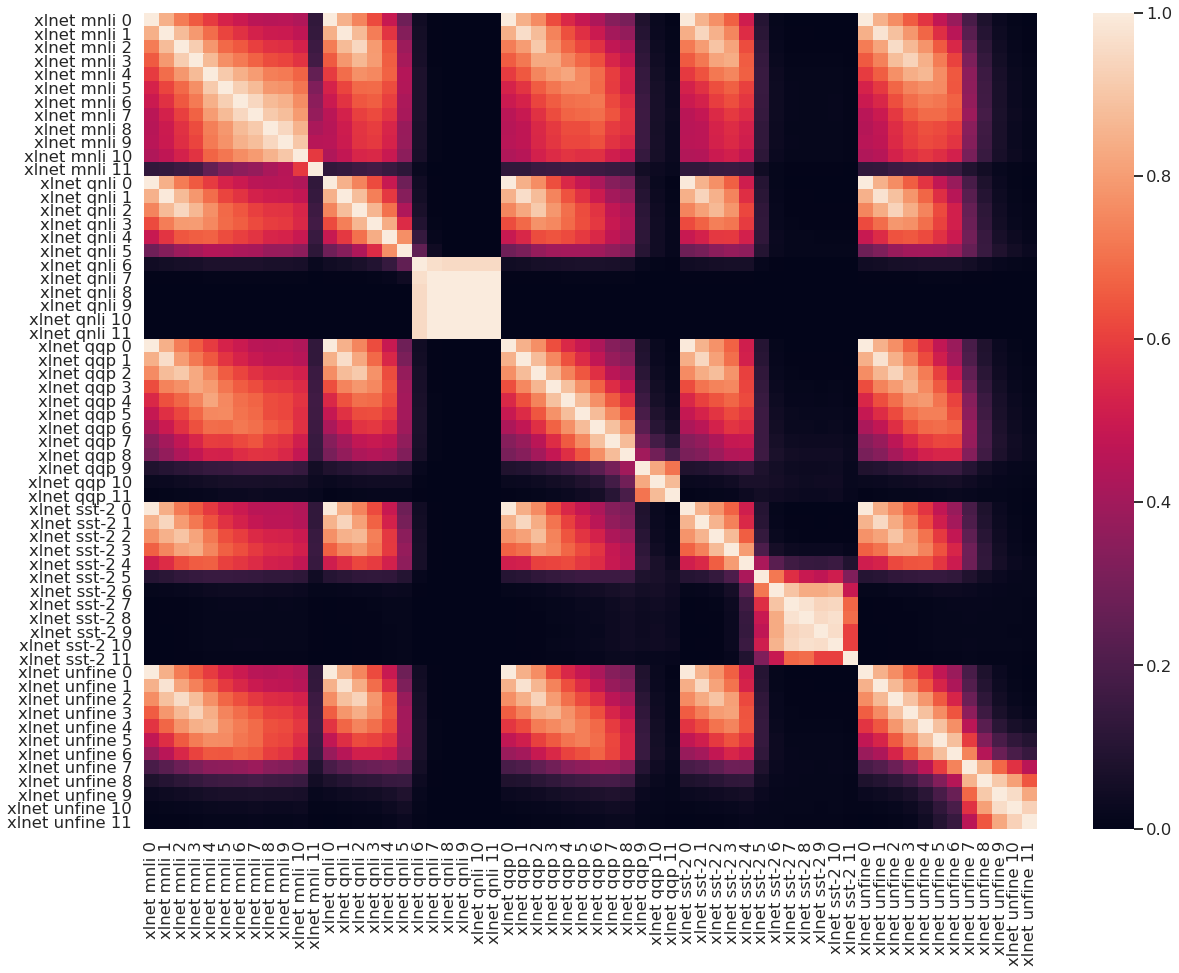

In [57]:
# lincka
short_labels = [label.split('_')[0] + ' ' + label.split('_')[-2].split('.')[0] + ' ' + label.split('_')[-1] for label in network_l]
g = sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1, xticklabels=short_labels, yticklabels=short_labels)
g.get_figure().savefig('xlnet-lincka-heatmap-finetuned.pdf')

In [22]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

In [23]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_fine_pw1_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [24]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_fine_sv1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [25]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_fine_maxmincorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [26]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_fine_linregcorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [27]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [28]:
# comparing models
# use lincka
model1 = "xlnet"
model2 = "xlnet"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

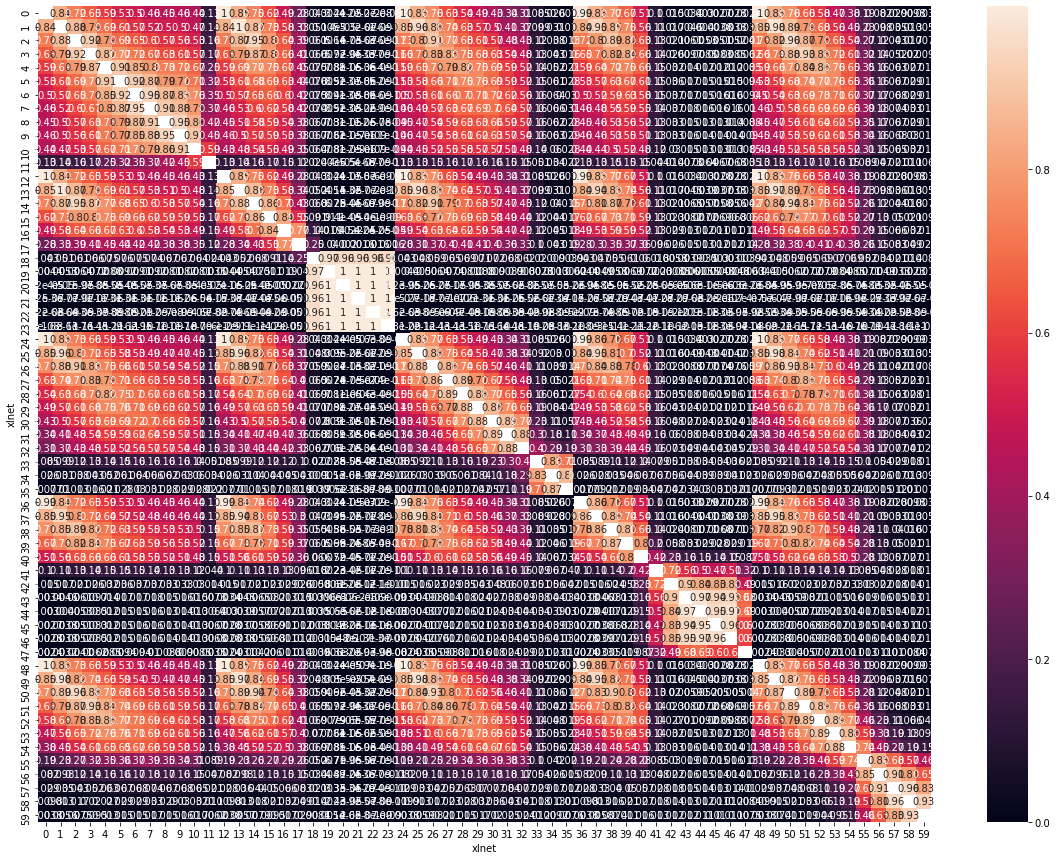

In [29]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()

# Localized vs distributed

In [30]:
locl_meth = "maxcorr"
dist_meth = "cca"

# Localized and distributed dataframes
locl_df = pd.DataFrame(res_d[locl_meth]['similarities'])
locl_df = locl_df.reindex(locl_df.columns)

dist_df = pd.DataFrame(res_d[dist_meth]['sv_similarities'])
dist_df = dist_df.reindex(dist_df.columns)

# Localization and distributivity statistics
locl_ser = locl_df.mean(axis=1)
locl_ser = (locl_ser - locl_ser.mean()) / locl_ser.std()

dist_ser = dist_df.mean(axis=1)
dist_ser = (dist_ser - dist_ser.mean()) / dist_ser.std()

# diff_ser
diff_ser = locl_ser - dist_ser

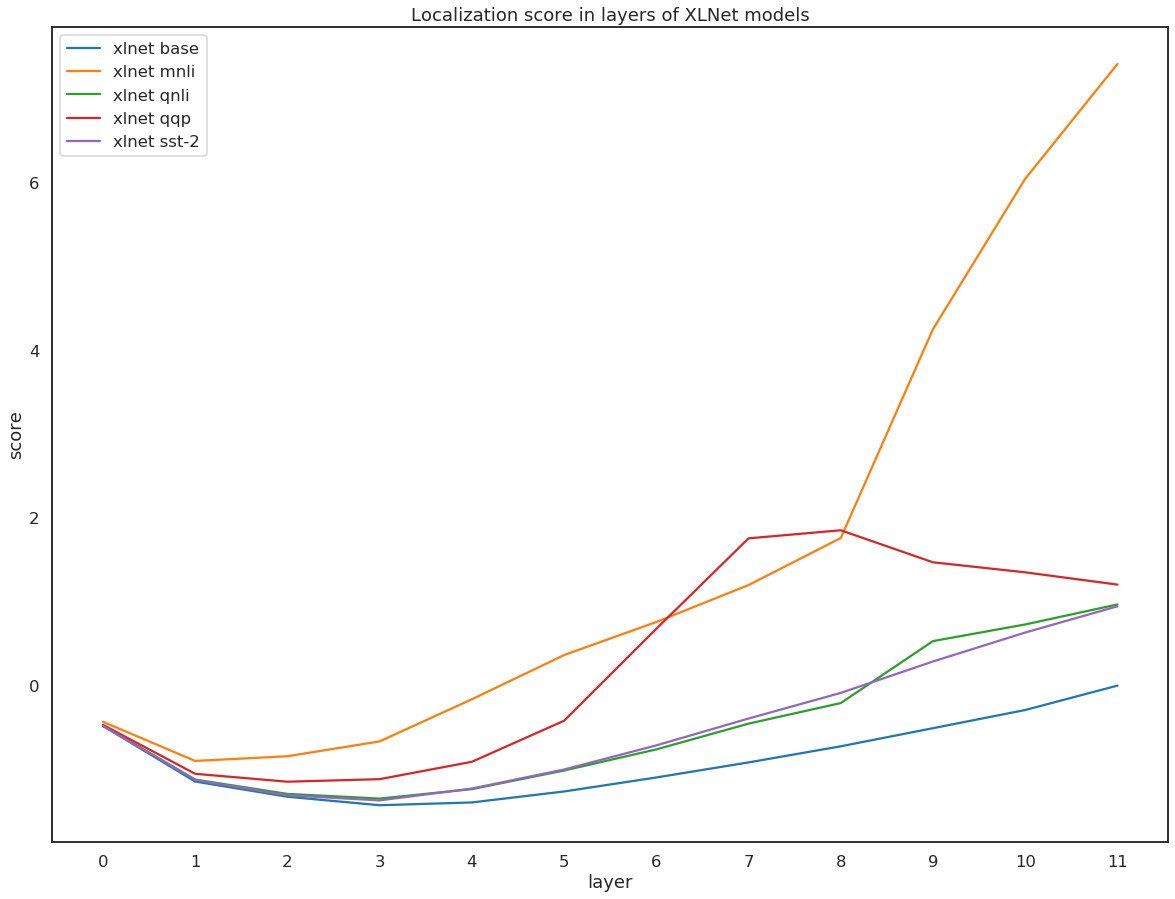

In [51]:
diff_df = pd.DataFrame(diff_ser, columns=['score'])
x = [network_sort_key(layer) for layer in diff_df.index.values]
models, layers = list(zip(*x))
models = [model.split('_')[0] + ' ' + model.split('_')[-1].split('.')[0] for model in models]
models = ['xlnet base' if model == 'xlnet unfine' else model for model in models]
# print(models)
# print(layers)
diff_df['layer'] = layers
diff_df['model'] = models
# diff_df.head()
g = sns.lineplot(data=diff_df, x='layer', y='score', hue='model', markers=True)
g.set_xticks(range(12))
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[1:], labels=labels[1:])
g.set_title('Localization score in layers of XLNet models')
g.get_figure().savefig('xlnet-loc-score.png')

In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(diff_ser.sort_values())

xlnet_base_cased-ptb_pos_dev_unfine.hdf5_3    -1.425651
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_4    -1.392495
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_3     -1.367705
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_3      -1.346457
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_2    -1.324194
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_2     -1.307439
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_2      -1.290431
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_5    -1.261509
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_4      -1.233511
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_4     -1.226700
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_2       -1.144879
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_1    -1.142855
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_1     -1.124276
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_1      -1.119534
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_3       -1.114719
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_6    -1.094458
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_1       -1.050632
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_5      -1

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(locl_ser.sort_values())

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_3       -0.226819
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_11     -0.226797
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_10    -0.226791
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_6       -0.226790
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_3     -0.226789
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11    -0.226781
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7       -0.226766
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_10     -0.226761
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_9     -0.226755
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_9      -0.226741
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_8     -0.226734
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_11   -0.226731
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       -0.226730
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      -0.226728
xlnet_base_cased-ptb_pos_dev_unfine.hdf5_3    -0.226725
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_2      -0.226723
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      -0.226717
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_3      -0

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(dist_ser.sort_values())

xlnet_base_cased-ptb_pos_dev_qqp.hdf5_8       -2.081118
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_7       -1.984958
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_10     -1.907852
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_9      -1.747458
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_9       -1.698917
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_11     -1.693386
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_8      -1.642907
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_10      -1.579578
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_11      -1.432977
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_7      -1.313421
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_11     -1.196529
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_11    -1.174589
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_10     -0.957652
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_6      -0.946087
xlnet_base_cased-ptb_pos_dev_qqp.hdf5_6       -0.906056
xlnet_base_cased-ptb_pos_dev_sst-2.hdf5_10    -0.861372
xlnet_base_cased-ptb_pos_dev_qnli.hdf5_9      -0.759350
xlnet_base_cased-ptb_pos_dev_mnli.hdf5_5      -0